# Beeler Reuter Model - Stimulation
In this notebook we will stimulate the dynamic Hodgkin Huxley Model with an $I_{stim}$ at a given duration $t_{stim}$
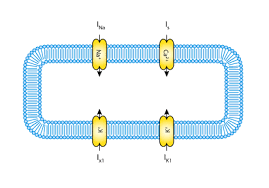

In [1]:
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Constants

In [67]:
# Cell membrane capacity
C_m = 1 # membrane capacitance (uF/cm^2)

# The fast Sodium current: INa
G_Na_Bar = 4 # max sodium conductance (mS/cm^2)
G_Na_C = 0.003 # max sodium conductance (mS/cm^2)
E_Na = 50 # sodium Nernst voltage (mV)
E_K = -77 # potassium Nernst voltage (mV)

# The calcium current
G_Ca_Bar = 0.09 # max sodium conductance (mS/cm^2)

# The Potassium currents
G_Na_Bar = 4 # max sodium conductance (mS/cm^2)
G_Na_C = 0.003 # max sodium conductance (mS/cm^2)
E_Na = 50 # sodium Nernst voltage (mV)
E_K = -77 # potassium Nernst voltage (mV)

G_K_max = 36 # max potassium conductance (mS/cm^2)

# leakage conductivity
G_L = 0.3 # leakage conductance (mS/cm^2)

V_rest = -65 # resting membrane voltage (mV)

# Nernst voltages
E_L = V_rest + 10.6 # leak Nernst voltage (mV)

In [68]:
def calc_gates(V_m):
    if V_m == -55:
        alpha_n = 1
    else:
        alpha_n =0.01 * (-(V_m + 55)/(np.exp(-(V_m + 55)/10)-1))
    beta_n = 0.125 * np.exp(-(V_m + 65)/80)
    
    if V_m == -40:
        alpha_m = 1
    else:
        alpha_m = 0.1 * (- (V_m + 40) / (np.exp(-(V_m + 40)/10)-1))
    beta_m = 4 * np.exp(-(V_m + 65)/18)
    alpha_h = 0.07 * np.exp(-(V_m + 65)/20)
    beta_h = 1/(np.exp(-(V_m + 35)/10)+1)
    return alpha_n, beta_n, alpha_m, beta_m, alpha_h, beta_h

## SImulation Properties

In [72]:
delta_t = 0.001
t_end = 10
timesteps = np.arange(0,t_end, delta_t)

n_timesteps = len(timesteps)

# initial values
n0 = 0.317711
m0 = 0.0529347
h0 = 0.596385
V0 = V_rest

I_stim = 25 # stimulus amplitude (uA/cm^2)
t_stim = 3 # stimulus duration (ms)

## Simulation

In [73]:
# variables
alpha_n = np.zeros((n_timesteps))
beta_n = np.zeros((n_timesteps))
alpha_m = np.zeros((n_timesteps))
beta_m = np.zeros((n_timesteps))
alpha_h = np.zeros((n_timesteps))
beta_h = np.zeros((n_timesteps))

n = np.zeros((n_timesteps))
n_dot = np.zeros((n_timesteps))
m = np.zeros((n_timesteps))
m_dot = np.zeros((n_timesteps))
h = np.zeros((n_timesteps))
h_dot = np.zeros((n_timesteps))

I_K = np.zeros((n_timesteps))
I_Na = np.zeros((n_timesteps))
I_L = np.zeros((n_timesteps))

V_m = np.zeros((n_timesteps))
V_m_dot = np.zeros((n_timesteps))

# initialize
V_m[0] = V0
n[0] = n0
m[0] = m0
h[0] = h0

# iterate
for t_index,t in enumerate(tqdm_notebook(timesteps)):   
    
    # calculate ion gates
    alpha_n[t_index], beta_n[t_index], alpha_m[t_index], beta_m[t_index], alpha_h[t_index], beta_h[t_index] = calc_gates(V_m[t_index])

    n_dot[t_index] = alpha_n[t_index] * (1 - n[t_index]) - beta_n[t_index] * n[t_index]
    m_dot[t_index] = alpha_m[t_index] * (1 - m[t_index]) - beta_m[t_index] * m[t_index]
    h_dot[t_index] = alpha_h[t_index] * (1 - h[t_index]) - beta_h[t_index] * h[t_index]

    if t_index < n_timesteps-1:
        n[t_index+1] = n[t_index] + n_dot[t_index] * delta_t
        m[t_index+1] = m[t_index] + m_dot[t_index] * delta_t
        h[t_index+1] = h[t_index] + h_dot[t_index] * delta_t

    # calculate ion currents
    I_K[t_index] = (V_m[t_index]-E_K) * G_K_max * n[t_index]**4
    I_Na[t_index] = (V_m[t_index]-E_Na) * G_Na_max * m[t_index]**3 * h[t_index]
    I_L[t_index] = (V_m[t_index]-E_L) * G_L
    
    # calcultate membrane voltage change
    V_m_dot[t_index] = - 1/C_m * (I_K[t_index] + I_Na[t_index] + I_L[t_index])
    if t < t_stim:
        V_m_dot[t_index] += I_stim
    
    # calcultate membrane voltage
    if t_index < n_timesteps-1:
        V_m[t_index+1] = V_m[t_index] + delta_t * V_m_dot[t_index]

## Plot Results

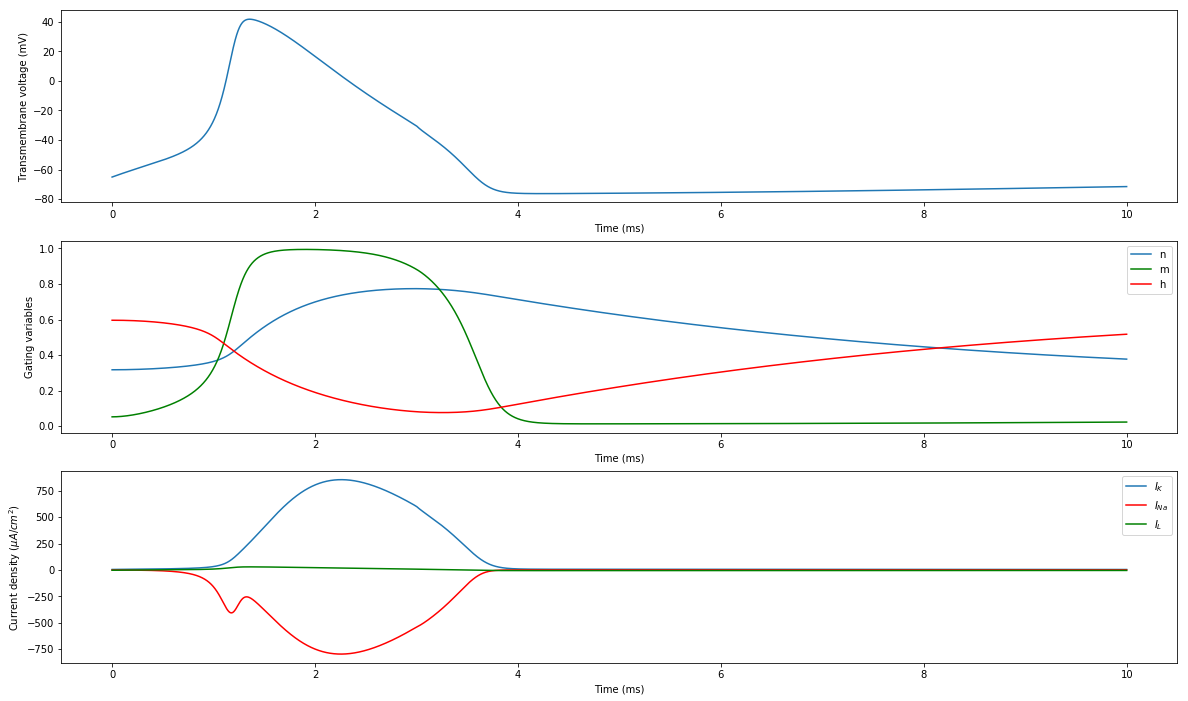

In [74]:
plt.figure(figsize=(20, 12))
plt.subplot(3,1,1)
plt.plot(timesteps,V_m)
plt.xlabel('Time (ms)')
plt.ylabel('Transmembrane voltage (mV)')

plt.subplot(3,1,2)
plt.plot(timesteps,n)
plt.plot(timesteps, m, 'g')
plt.plot(timesteps,h,'r')
plt.legend(['n','m','h'])
plt.xlabel('Time (ms)')
plt.ylabel('Gating variables')

plt.subplot(3,1,3)
plt.plot(timesteps,I_K)
plt.plot(timesteps, I_Na,'r')
plt.plot(timesteps,I_L,'g')
plt.legend(['$I_K$','$I_{Na}$','$I_L$'])
plt.xlabel('Time (ms)')
plt.ylabel('Current density ($\mu A/cm^2$)')
plt.show()